In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Corrected raw path (no trailing backslash)
base_path = r"C:\Users\Administrator\Downloads\Python\Python_Data_Project\turbofan-rul-prediction\CMAPSSData\data\raw"

# File paths
train_path = base_path + r"\train_FD001.txt"
test_path  = base_path + r"\test_FD001.txt"
rul_path   = base_path + r"\RUL_FD001.txt"

# Column names: 1 unit + 1 cycle + 3 op settings + 21 sensors = 26 total
column_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Load data
train_df = pd.read_csv(train_path, sep="\s+", header=None, names=column_names)
test_df = pd.read_csv(test_path, sep="\s+", header=None, names=column_names)
rul_df = pd.read_csv(rul_path, sep="\s+", header=None, names=['RUL'])

# Confirm load
print("✅ Loaded:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"RUL shape:   {rul_df.shape}")



✅ Loaded:
Train shape: (20631, 26)
Test shape:  (13096, 26)
RUL shape:   (100, 1)


In [2]:
# 🧮 Add RUL to Training Set

# Compute the max cycle for each engine
rul_train = train_df.groupby('unit')['cycle'].max().reset_index()
rul_train.columns = ['unit', 'max_cycle']

# Merge to calculate RUL
train_df = train_df.merge(rul_train, on='unit', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Preview
train_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [3]:
#🧮 Add RUL to Test Set

# Compute the max cycle per engine in test set
rul_test = test_df.groupby('unit')['cycle'].max().reset_index()
rul_test.columns = ['unit', 'max_cycle']

# Attach provided RUL values (from RUL_FD001.txt)
rul_df['unit'] = rul_test['unit']
rul_test = rul_test.merge(rul_df, on='unit', how='left')

# Merge with test_df and compute RUL for each row
test_df = test_df.merge(rul_test, on='unit', how='left')
test_df['RUL'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['cycle'])
test_df.drop('max_cycle', axis=1, inplace=True)

# Preview
test_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


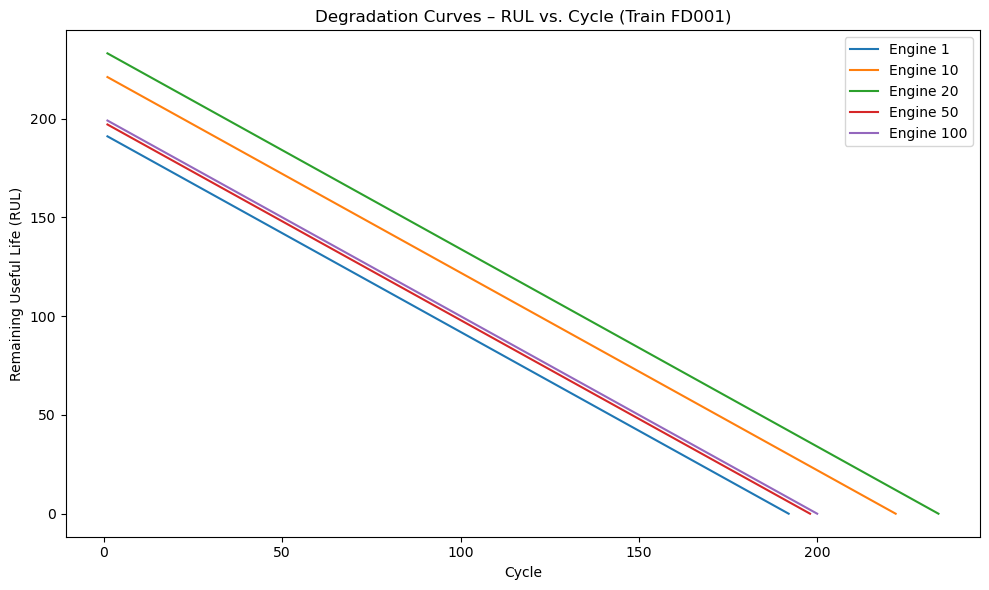

In [4]:
# 📊 Quick Visualization: Sample Degradation Curves

engines_to_plot = [1, 10, 20, 50, 100]

plt.figure(figsize=(10, 6))
for uid in engines_to_plot:
    df = train_df[train_df['unit'] == uid]
    plt.plot(df['cycle'], df['RUL'], label=f"Engine {uid}")

plt.title("Degradation Curves – RUL vs. Cycle (Train FD001)")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# ✅ STEP 2.1: Sensor Selection (Remove Flat/Noisy Columns)
#Some sensors don’t change much and are not helpful. Let’s find them.

# View the variance of each sensor
sensor_cols = [col for col in train_df.columns if 'sensor_' in col]
train_df[sensor_cols].describe().T[['mean', 'std']].sort_values('std')

,mean,std
sensor_19,100.000000,0.000000e+00
sensor_18,2388.000000,0.000000e+00
sensor_16,0.030000,1.556432e-14
sensor_10,1.300000,4.660829e-13
sensor_5,14.620000,3.394700e-12
sensor_1,518.670000,6.537152e-11
sensor_6,21.609803,1.388985e-03
sensor_15,8.442146,3.750504e-02
sensor_8,2388.096652,7.098548e-02
sensor_13,2388.096152,7.191892e-02


In [6]:
# From prior studies on C-MAPSS, commonly retained sensors for FD001 are:

selected_sensors = [
    'sensor_2', 'sensor_3', 'sensor_4',
    'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_13',
    'sensor_14', 'sensor_15', 'sensor_17',
    'sensor_20', 'sensor_21'
]

In [7]:
# You can also include the 3 operational settings if desired:

features = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + selected_sensors

In [8]:
# ✅ STEP 2.2: Normalize (Standard Scaling)
# This is essential if you're using models that are sensitive to scale (e.g., regression, neural nets).

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
scaler.fit(train_df[features])

# Transform train and test
train_df[features] = scaler.transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

In [9]:
# ✅ STEP 2.3: Create Feature Matrix (X) and Target (y)
# This will get your data ready for traditional models (Random Forest, XGBoost, etc.)

X_train = train_df[features]
y_train = train_df['RUL']

X_test = test_df[features]
y_test = test_df['RUL']
